In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import glob

# Deep Learning - YOLO Approach

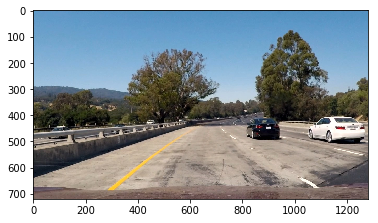

In [2]:
img = plt.imread("test_images/test1.jpg")
plt.imshow(img)

In [3]:
def crop(img):
    return img[300:650,500:,:]

In [4]:
def resize(img):
    return cv2.resize(img, (448,448))

In [5]:
def normalize(img):
    return 2.0*img/255.0 - 1

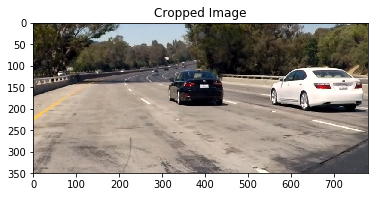

In [6]:
cimg=crop(img)
plt.imshow(cimg)
plt.title("Cropped Image")

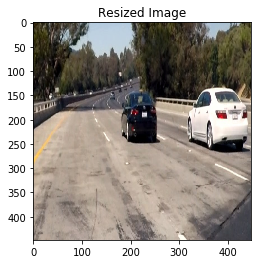

In [7]:
plt.imshow(resize(cimg))
plt.title("Resized Image")

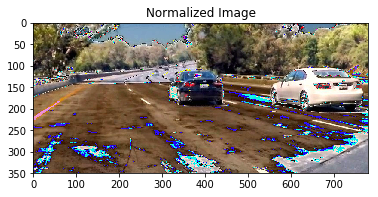

In [8]:
plt.imshow(normalize(cimg))
plt.title("Normalized Image")

In [9]:
def overlap(x1,w1,x2,w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left

In [10]:
class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
def box_intersection(a, b):
    """
    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area
def box_union(a, b):
    """
    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u
def box_iou(a, b):
    """
    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)
def yolo(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):
    # Position for class 'car' in the VOC dataset classes
    car_class_number = 6
    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell
    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]
    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))
    for grid in range(SS):
        for b in range(B):
            bx = Box()
            bx.c = confs[grid, b]
            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S
            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt
            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c
            # Check if the confidence score for class 'car' is greater than the threshold
            if p[car_class_number] >= threshold:
                bx.prob = p[car_class_number]
                boxes.append(bx)
    # combine boxes that are overlap
    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)
    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue
        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]
            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0
    boxes = [b for b in boxes if b.prob > 0]
    return boxes
def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin
        left  = int((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin
        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        thick = 5 #int((height + width // 150))
        cv2.rectangle(imgcv1, (left, top), (right, bot), (0,255,0), thick)
    return imgcv1

In [11]:
def load_weight(model , weight):
    data = np.fromfile(weight, np.float32)
    data = data[4:]
    index = 0
    for layer in model.layers:
        shape = [w.shape for w in layer.get_weights()]
        if shape != []:
            kshape, bshape = shape
            bia = data[index:index + np.prod(bshape)].reshape(bshape)
            index += np.prod(bshape)
            ker = data[index:index + np.prod(kshape)].reshape(kshape)
            index += np.prod(kshape)
            layer.set_weights([ker, bia])

## The Model Weights have been picked up from PASCAL VOC the link is https://drive.google.com/uc?id=0B1tW_VtY7onibmdQWE1zVERxcjQ&export=download 

In [12]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.


In [13]:
def model():
    keras.backend.set_image_dim_ordering('th')
    model = Sequential()
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(1470))
    return model

In [14]:
model = model()

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [16]:
load_weight(model,'yolo-tiny.weights')

In [17]:
imagePath = './test_images/test3.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [18]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

In [19]:
boxes = yolo(out[0], threshold = 0.17)

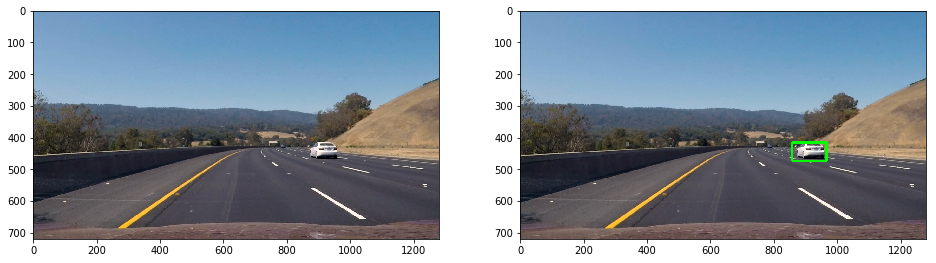

In [20]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_boxes(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

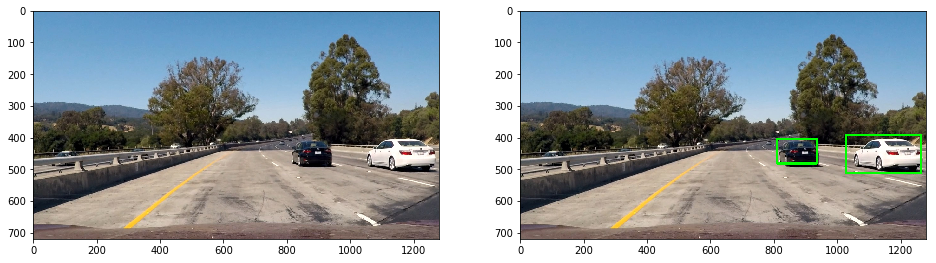

In [21]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)
boxes = yolo(out[0], threshold = 0.17)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_boxes(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

In [24]:
def crop_and_resize(image):
    cropped = image[300:650,500:,:]
    return cv2.resize(cropped, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed
def pipeline1(image):
    pre_processed = preprocess(image)
    batch = np.expand_dims(pre_processed, axis=0)
    batch_output = model.predict(batch)
    boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.20)
    final = draw_boxes(boxes, image, ((500,1280),(300,650)))
    return final

In [22]:
def pipeline(image):
    crop1 = crop(image)
    resized = cv2.resize(crop1,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    normal = normalize(batch)
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo(out[0], threshold = 0.17)
    return draw_boxes(boxes,image,[[520,1250],[295,660]])

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
lane_clip = clip1.fl_image(pipeline1) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:51<00:00,  3.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 6min 52s
